In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
!pip install kaggle
!kaggle -h

usage: kaggle [-h] [-v] [-W]
              {competitions,c,datasets,d,kernels,k,models,m,files,f,config}
              ...

options:
  -h, --help            show this help message and exit
  -v, --version         Print the Kaggle API version
  -W, --no-warn         Disable out-of-date API version warning

commands:
  {competitions,c,datasets,d,kernels,k,models,m,files,f,config}
                        Use one of:
                        competitions {list, files, download, submit, submissions, leaderboard}
                        datasets {list, files, download, create, version, init, metadata, status}
                        kernels {list, files, init, push, pull, output, status}
                        models {instances, get, list, init, create, delete, update}
                        models instances {versions, get, files, init, create, delete, update}
                        models instances versions {init, create, download, delete, files}
                        config {view, set,

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import seaborn as sb
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, KFold,GridSearchCV
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.preprocessing import StandardScaler,RobustScaler,LabelEncoder,PowerTransformer
from sklearn.ensemble import GradientBoostingRegressor,StackingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA



# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 5000)


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/kaggle/kaggle_estyle/input/estyle-community-competition-2025/train.csv')
test = pd.read_csv('/content/drive/MyDrive/kaggle/kaggle_estyle/input/estyle-community-competition-2025/test.csv')
sample_sub = pd.read_csv('/content/drive/MyDrive/kaggle/kaggle_estyle/input/estyle-community-competition-2025/sample_submission.csv')

In [ ]:
train.head()

,Id,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,FloorPlan,Area,AreaIsGreaterFlag,LandShape,Frontage,FrontageIsGreaterFlag,TotalFloorArea,TotalFloorAreaIsGreaterFlag,BuildingYear,PrewarBuilding,Structure,Use,Purpose,Direction,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Year,Quarter,Renovation,Remarks
0,1,Agricultural Land,NaN,9201,Tochigi Prefecture,Utsunomiya City,Ainosawacho,NaN,NaN,NaN,NaN,9700000,NaN,5000,1,NaN,NaN,False,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,3,NaN,NaN
1,2,Agricultural Land,NaN,9201,Tochigi Prefecture,Utsunomiya City,Ainosawacho,NaN,NaN,NaN,NaN,9500000,NaN,5000,1,NaN,NaN,False,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,4,NaN,NaN
2,3,Residential Land(Land and Building),Residential Area,9201,Tochigi Prefecture,Utsunomiya City,Akebonocho,Minamiutsunomiya,12,12.0,12.0,33000000,NaN,290,0,Semi-rectangular Shaped,12.5,False,320.0,0,1992.0,0,S,Housing Complex,House,North,City Road,6.0,Category I Residential Zone,60.0,200.0,2018,3,NaN,NaN
3,4,Residential Land(Land Only),Commercial Area,9201,Tochigi Prefecture,Utsunomiya City,Akebonocho,Minamiutsunomiya,14,14.0,14.0,150000000,NaN,1800,0,Irregular Shaped,43.5,False,NaN,0,NaN,0,NaN,NaN,Other,West,Prefectural Road,20.5,Category II Residential Zone,60.0,200.0,2014,3,NaN,NaN
4,5,Residential Land(Land Only),Commercial Area,9201,Tochigi Prefecture,Utsunomiya City,Akebonocho,Minamiutsunomiya,14,14.0,14.0,7200000,NaN,120,0,Semi-shaped,9.5,False,NaN,0,NaN,0,NaN,NaN,Other,North,City Road,21.0,Category II Residential Zone,60.0,200.0,2014,3,NaN,NaN


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 35 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Id                           300000 non-null  int64  
 1   Type                         300000 non-null  object 
 2   Region                       205418 non-null  object 
 3   MunicipalityCode             300000 non-null  int64  
 4   Prefecture                   300000 non-null  object 
 5   Municipality                 300000 non-null  object 
 6   DistrictName                 299853 non-null  object 
 7   NearestStation               290777 non-null  object 
 8   TimeToNearestStation         287266 non-null  object 
 9   MinTimeToNearestStation      287266 non-null  float64
 10  MaxTimeToNearestStation      284129 non-null  float64
 11  TradePrice                   300000 non-null  int64  
 12  FloorPlan                    83230 non-null   object 
 13 

In [ ]:
bad_cols = [c for c in train.columns if train[c].dtype != 'object' and pd.to_numeric(train[c], errors='coerce').isna().sum() > train[c].isna().sum()]


In [ ]:
print(bad_cols)

[]


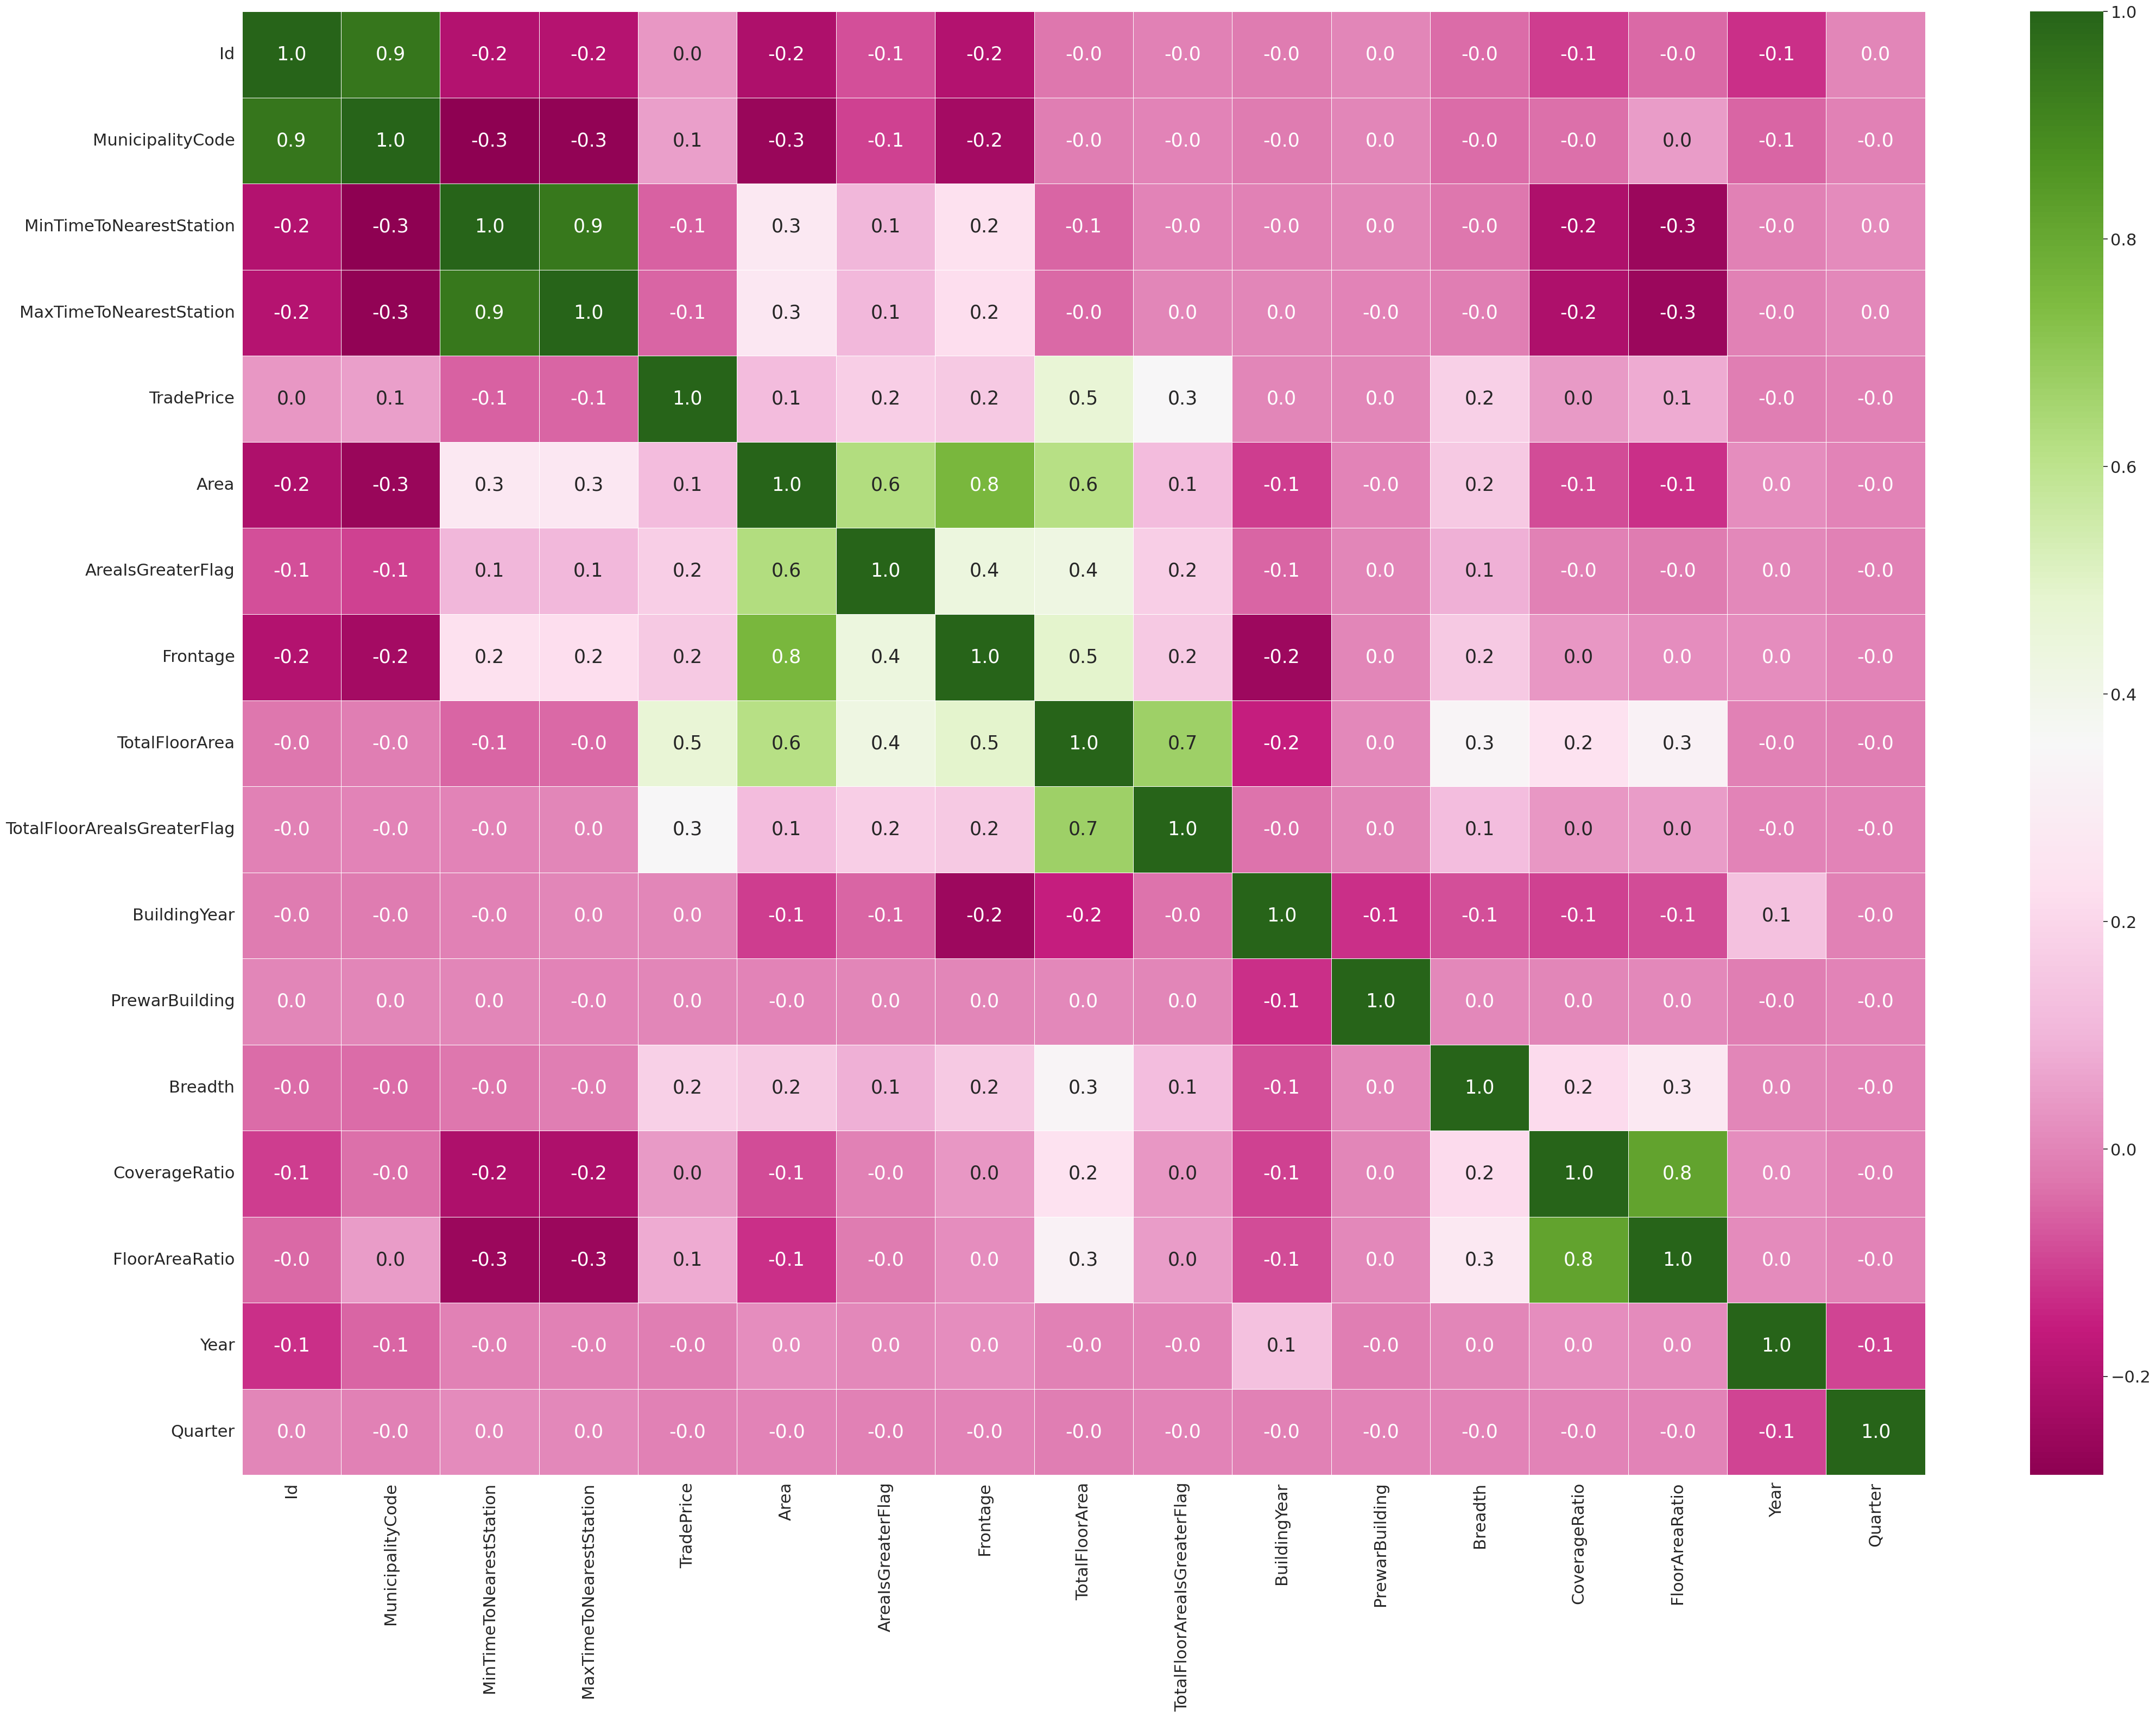

In [ ]:
correlation_train=train.select_dtypes(include='number').corr()
sb.set(font_scale=2)
plt.figure(figsize = (50,35))
ax = sb.heatmap(correlation_train, annot=True,annot_kws={"size": 25},fmt='.1f',cmap='PiYG', linewidths=.5)

In [ ]:
corr_dict=correlation_train['TradePrice'].sort_values(ascending=False).to_dict()
important_columns=[]
for key,value in corr_dict.items():
    if ((value>0.1) & (value<0.8)) | (value<=-0.1):
        important_columns.append(key)
important_columns

['TotalFloorArea',
 'TotalFloorAreaIsGreaterFlag',
 'Breadth',
 'AreaIsGreaterFlag',
 'Frontage',
 'Area']

In [ ]:
# plt.figure(figsize=(40,20))
# sb.set(font_scale=1.5)
# sb.boxplot(x='BuildingYear', y="TradePrice", data=train)
# sb.swarmplot(x='BuildingYear', y="TradePrice", data=train, color=".25")
# plt.xticks(weight='bold',rotation=90)

In [164]:
train['TradePrice_Log1p'] = np.log1p(train['TradePrice'])

In [166]:
print(min(train['TradePrice_Log1p']))
print(max(train['TradePrice_Log1p']))

5.739792912179234
24.1244632186419


Skew Dist: 53.74254598886322
Kurtosis Dist: 4637.13894260084


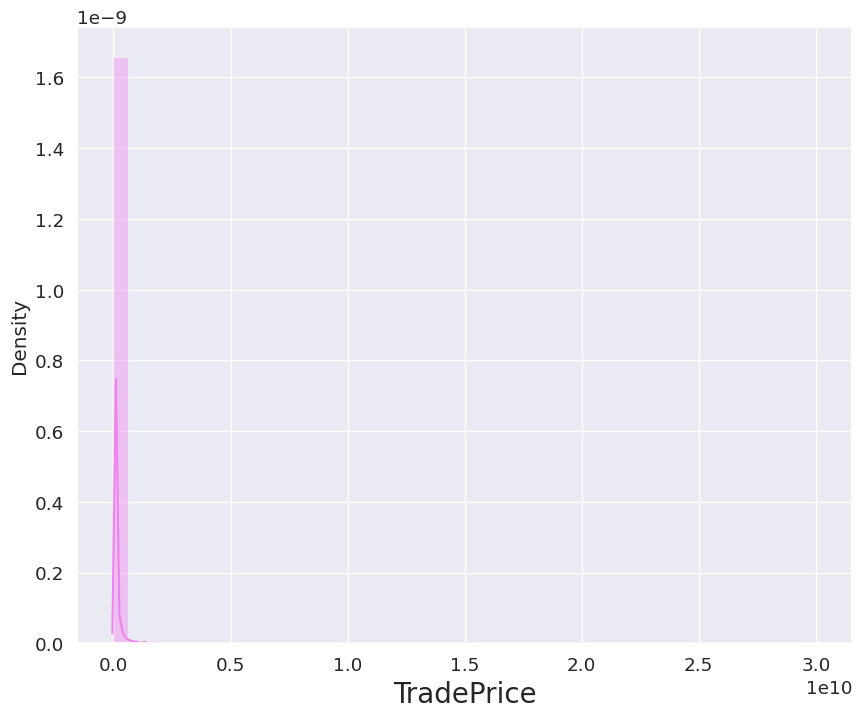

In [167]:
plt.figure(figsize=(10,8))
sb.set(font_scale=1.2)
sb.distplot(train['TradePrice'],color='violet')
plt.xlabel('TradePrice',fontsize=20)
print('Skew Dist:',train['TradePrice'].skew())
print('Kurtosis Dist:',train['TradePrice'].kurt())

Skew Dist: -1.00986216807561
Kurtosis Dist: 4.301767034529073


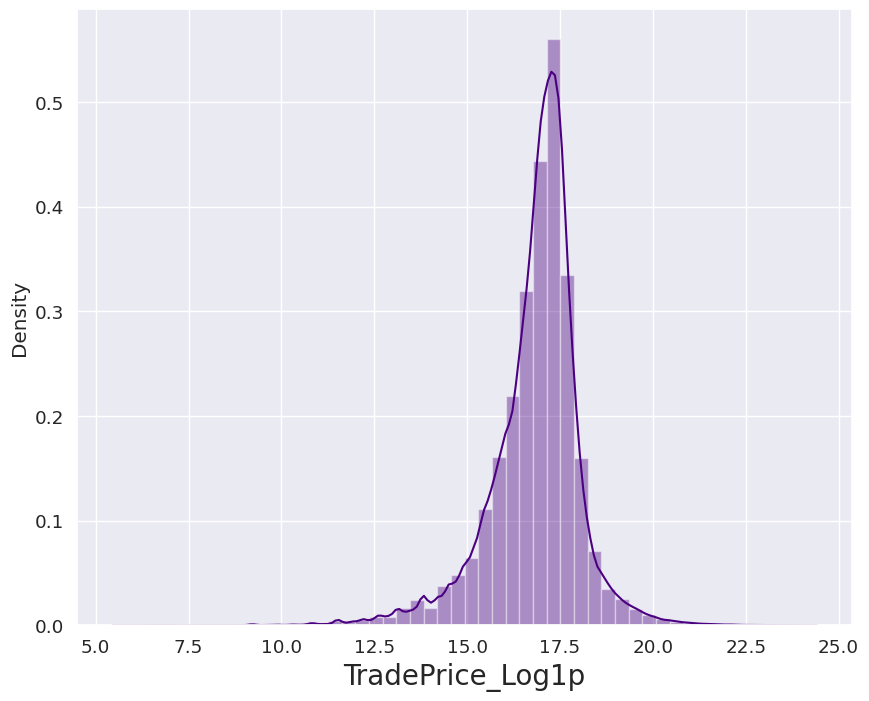

In [168]:
plt.figure(figsize=(10,8))
sb.set(font_scale=1.2)
sb.distplot(train['TradePrice_Log1p'],color='indigo')
plt.xlabel('TradePrice_Log1p',fontsize=20)
print('Skew Dist:',train['TradePrice_Log1p'].skew())
print('Kurtosis Dist:',train['TradePrice_Log1p'].kurt())

In [ ]:
train_test=pd.concat([train,test],axis=0,sort=False)
train_test.head()

,Id,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,FloorPlan,Area,AreaIsGreaterFlag,LandShape,Frontage,FrontageIsGreaterFlag,TotalFloorArea,TotalFloorAreaIsGreaterFlag,BuildingYear,PrewarBuilding,Structure,Use,Purpose,Direction,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Year,Quarter,Renovation,Remarks
0,1,Agricultural Land,NaN,9201,Tochigi Prefecture,Utsunomiya City,Ainosawacho,NaN,NaN,NaN,NaN,9700000.0,NaN,5000,1,NaN,NaN,False,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,3,NaN,NaN
1,2,Agricultural Land,NaN,9201,Tochigi Prefecture,Utsunomiya City,Ainosawacho,NaN,NaN,NaN,NaN,9500000.0,NaN,5000,1,NaN,NaN,False,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,4,NaN,NaN
2,3,Residential Land(Land and Building),Residential Area,9201,Tochigi Prefecture,Utsunomiya City,Akebonocho,Minamiutsunomiya,12,12.0,12.0,33000000.0,NaN,290,0,Semi-rectangular Shaped,12.5,False,320.0,0,1992.0,0,S,Housing Complex,House,North,City Road,6.0,Category I Residential Zone,60.0,200.0,2018,3,NaN,NaN
3,4,Residential Land(Land Only),Commercial Area,9201,Tochigi Prefecture,Utsunomiya City,Akebonocho,Minamiutsunomiya,14,14.0,14.0,150000000.0,NaN,1800,0,Irregular Shaped,43.5,False,NaN,0,NaN,0,NaN,NaN,Other,West,Prefectural Road,20.5,Category II Residential Zone,60.0,200.0,2014,3,NaN,NaN
4,5,Residential Land(Land Only),Commercial Area,9201,Tochigi Prefecture,Utsunomiya City,Akebonocho,Minamiutsunomiya,14,14.0,14.0,7200000.0,NaN,120,0,Semi-shaped,9.5,False,NaN,0,NaN,0,NaN,NaN,Other,North,City Road,21.0,Category II Residential Zone,60.0,200.0,2014,3,NaN,NaN


In [ ]:
pd.set_option('display.max_rows', 5000)
train_test_null_info=pd.DataFrame(train_test.isnull().sum(),columns=['Count of NaN'])
train_test_dtype_info=pd.DataFrame(train_test.dtypes,columns=['DataTypes'])
train_tes_info=pd.concat([train_test_null_info,train_test_dtype_info],axis=1)
train_tes_info

,Count of NaN,DataTypes
Id,0,int64
Type,0,object
Region,284069,object
MunicipalityCode,0,int64
Prefecture,0,object
Municipality,0,object
DistrictName,460,object
NearestStation,27494,object
TimeToNearestStation,38271,object
MinTimeToNearestStation,38271,float64


# Create Model

In [ ]:
test.head()

,Id,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,FloorPlan,Area,AreaIsGreaterFlag,LandShape,Frontage,FrontageIsGreaterFlag,TotalFloorArea,TotalFloorAreaIsGreaterFlag,BuildingYear,PrewarBuilding,Structure,Use,Purpose,Direction,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Year,Quarter,Renovation,Remarks
0,300001,Residential Land(Land and Building),Residential Area,9201,Tochigi Prefecture,Utsunomiya City,Akebonocho,Minamiutsunomiya,26,26.0,26.0,NaN,200,0,Rectangular Shaped,10.0,False,150.0,0,1982.0,0,W,House,House,North,City Road,6.3,Category I Residential Zone,60.0,200.0,2016,1,NaN,Dealings in which auction or arbiter participates
1,300002,Residential Land(Land and Building),Residential Area,9201,Tochigi Prefecture,Utsunomiya City,Akebonocho,Minamiutsunomiya,8,8.0,8.0,NaN,430,0,Irregular Shaped,17.0,False,890.0,0,1991.0,0,S,"Housing Complex, Office",NaN,South,City Road,11.0,Category I Residential Zone,60.0,200.0,2014,1,NaN,NaN
2,300003,Residential Land(Land and Building),Commercial Area,9201,Tochigi Prefecture,Utsunomiya City,Akebonocho,Minamiutsunomiya,11,11.0,11.0,NaN,2000,1,Rectangular Shaped,43.0,False,2000.0,1,NaN,0,"SRC, RC",Office,NaN,North,City Road,16.0,Category II Residential Zone,60.0,200.0,2014,1,NaN,NaN
3,300004,"Pre-owned Condominiums, etc.",NaN,9201,Tochigi Prefecture,Utsunomiya City,Asahi,Utsunomiya,19,19.0,19.0,NaN,65,0,NaN,NaN,False,NaN,0,NaN,0,NaN,NaN,House,NaN,NaN,NaN,NaN,NaN,NaN,2019,2,NaN,NaN
4,300005,"Pre-owned Condominiums, etc.",NaN,9201,Tochigi Prefecture,Utsunomiya City,Asahi,Tobuutsunomiya,8,8.0,8.0,3LDK,65,0,NaN,NaN,False,NaN,0,NaN,0,NaN,NaN,House,NaN,NaN,NaN,NaN,NaN,NaN,2018,1,NaN,NaN


In [ ]:
# 特徴量列を明示的に固定（Id と 目的変数を除く）
feature_cols = [c for c in train.columns if c not in ['Id', 'TradePrice','TradePrice_Log1p']]

X = train[feature_cols]
y = train.TradePrice_Log1p


In [ ]:
obj_cols = X.select_dtypes(include=['object']).columns

In [ ]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

for col in obj_cols:  # 文字列列の一覧
    le = LabelEncoder()
    both = pd.concat([X[col].fillna("__MISSING__"),
                      test[col].fillna("__MISSING__")], axis=0)
    le.fit(both)
    X[col]    = le.transform(X[col].fillna("__MISSING__"))
    test[col] = le.transform(test[col].fillna("__MISSING__"))


In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=52)
print('X_train Shape :',X_train.shape)
print('X_test Shape :',X_test.shape)
print('y_train Shape :',y_train.shape)
print('y_test Shape :',y_test.shape)

X_train Shape : (240000, 33)
X_test Shape : (60000, 33)
y_train Shape : (240000,)
y_test Shape : (60000,)


In [ ]:
lgb_regressor=lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    feature_fraction=0.201,   # colsample_bytree は書かない
    bagging_fraction=0.65,    # subsample は書かない
    bagging_freq=5,           # subsample_freq は書かない
    n_jobs=-1,
    # 必要なら：
    # force_row_wise=True
)
lgb_regressor.fit(X_train, y_train)
y_head=lgb_regressor.predict(X_test)
print('-'*10+'LGBM'+'-'*10)
print('R square Accuracy: ',r2_score(y_test,y_head))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_head))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_head))

[LightGBM] [Warning] feature_fraction is set=0.201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.201
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.201
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2151
[LightGBM] [Info] Number of da

In [ ]:
test_ids = test['Id'].copy()
sub_test  = test[feature_cols]
test_pred = lgb_regressor.predict(sub_test)

submission = pd.DataFrame({'Id': test_ids, 'TradePrice': test_pred})

[LightGBM] [Warning] feature_fraction is set=0.201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.201
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [ ]:
submission.to_csv('/content/drive/MyDrive/kaggle/kaggle_estyle/output/Sample_submit.csv',index=False)